In [1]:
import pandas as pd 
import numpy as np
from sklearn import preprocessing
import sys
from sklearn.model_selection import train_test_split    
import  matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
import random
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from IPython.core.display import display, HTML
import base64
from facets_overview.generic_feature_statistics_generator import GenericFeatureStatisticsGenerator
import shap
import seaborn as sns
import tensorflow as tf 
from tensorflow import keras

In [2]:
df = pd.read_csv("stroke-data.csv")

In [3]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
df = df.drop('id',axis=1)

In [5]:
import ipyfacets as facets


In [6]:
facets.overview({'train':df})

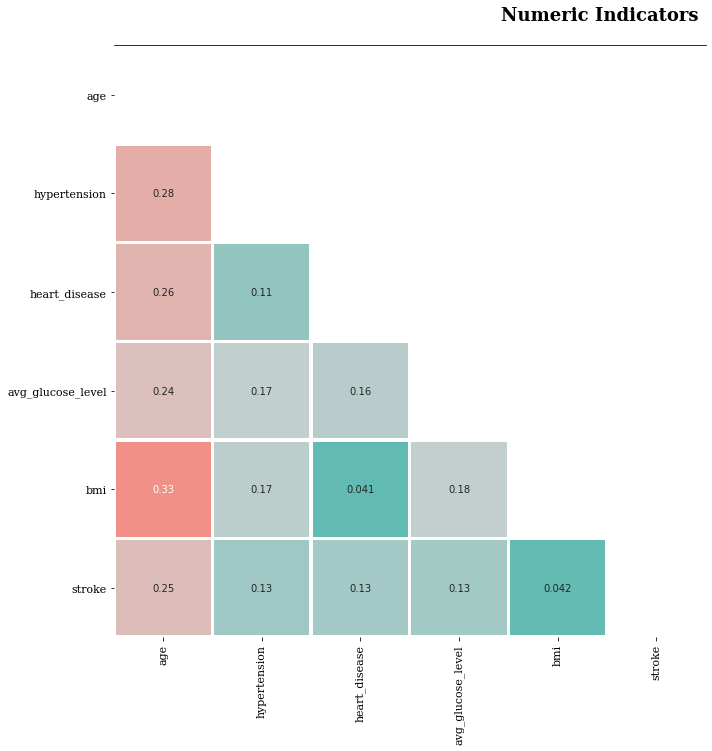

In [7]:
import matplotlib
corr_df = df

#background_color = "#fbfbfb"
#fig.patch.set_facecolor(background_color) # figure background color

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#ax.set_facecolor(background_color) 
corr = corr_df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

colors = ["#45b5aa","lightgray", "#ff6f61"]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

sns.heatmap(corr, 
            square=True, 
            mask=mask,
            linewidth=2.5, 
            vmax=0.4, vmin=0, 
            cmap=cmap, 
            cbar=False, 
            ax=ax,annot=True)

ax.set_yticklabels(ax.get_xticklabels(), fontfamily='serif', rotation = 0, fontsize=11)
ax.set_xticklabels(ax.get_xticklabels(), fontfamily='serif', rotation=90, fontsize=11)

ax.spines['top'].set_visible(True)

fig.text(0.97, 1.02, 'Numeric Indicators', fontweight='bold', fontfamily='serif', fontsize=18, ha='right')    


plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='age', ylabel='Count'>

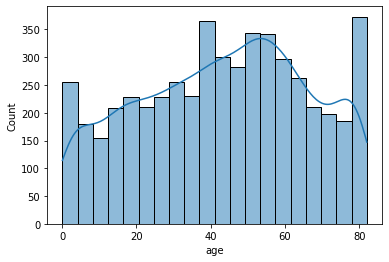

In [8]:
sns.histplot(df['age'],kde=True)

In [9]:
d = GenericFeatureStatisticsGenerator()

In [10]:
proto = d.ProtoFromDataFrames([{'name':'data','table':df}])

In [11]:

protostr = base64.b64encode(proto.SerializeToString()).decode("utf-8")
HTML_TEMPLATE = """

<link rel="import" href="/nbextensions/facets-dist/facets-jupyter.html" >
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

In [12]:
datamod =pd.get_dummies(df,columns=['work_type','smoking_status','gender'])

In [13]:
datamod['Residence_type']= datamod['Residence_type'].replace('Urban',0)
datamod['Residence_type']= datamod['Residence_type'].replace('Rural',1)
# datamod['gender'] = datamod['gender'].replace('Male',0)
# datamod['gender'] = datamod['gender'].replace('Female',1)
datamod['ever_married'] =  datamod['ever_married'].replace('Yes',1)
datamod['ever_married'] = datamod['ever_married'].replace('No',0)

In [14]:
datamod['bmi']= datamod['bmi'].fillna(0)

In [15]:
sns.heatmap(datamod, 
            square=True, 
           
            linewidth=2.5, 
            vmax=0.4, vmin=0, 
            cmap=cmap, 
            cbar=False, 
            ax=ax,annot=True)
plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

In [16]:
datamod = datamod[['age','gender_Male','gender_Female','gender_Other','hypertension','heart_disease','ever_married','Residence_type','avg_glucose_level','bmi','work_type_Govt_job','work_type_Never_worked','work_type_Private','work_type_Self-employed','work_type_children','smoking_status_Unknown','smoking_status_formerly smoked','smoking_status_never smoked','smoking_status_smokes','stroke']]

In [17]:
datamod

,age,gender_Male,gender_Female,gender_Other,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke
0,67.0,1,0,0,0,1,1,0,228.69,36.6,0,0,1,0,0,0,1,0,0,1
1,61.0,0,1,0,0,0,1,1,202.21,0.0,0,0,0,1,0,0,0,1,0,1
2,80.0,1,0,0,0,1,1,1,105.92,32.5,0,0,1,0,0,0,0,1,0,1
3,49.0,0,1,0,0,0,1,0,171.23,34.4,0,0,1,0,0,0,0,0,1,1
4,79.0,0,1,0,1,0,1,1,174.12,24.0,0,0,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,80.0,0,1,0,1,0,1,0,83.75,0.0,0,0,1,0,0,0,0,1,0,0
5106,81.0,0,1,0,0,0,1,0,125.20,40.0,0,0,0,1,0,0,0,1,0,0
5107,35.0,0,1,0,0,0,1,1,82.99,30.6,0,0,0,1,0,0,0,1,0,0
5108,51.0,1,0,0,0,0,1,1,166.29,25.6,0,0,1,0,0,0,1,0,0,0


# Data Smote

In [18]:

Y = datamod['stroke']
X = (pd.DataFrame(datamod.drop('stroke',axis=1)))


In [19]:
sm = SMOTE()

In [20]:
X.shape[1:]

(19,)

In [21]:
X_sm,Y_sm = sm.fit_resample(X,Y)

In [72]:
X_train,X_test,Y_train,Y_test = train_test_split(X_sm,Y_sm , test_size=0.2,random_state=5)
X_train,X_val,Y_train,Y_val = train_test_split(X_train,Y_train , test_size=0.1,random_state=6)

In [148]:
model = keras.Sequential([
    keras.Input(shape=X_train.shape[1:]),
   # keras.layers.Dense(128,activation="relu"),
    keras.layers.Dense(16,activation="relu"),
    keras.layers.Dropout(0.1),

   
     

    keras.layers.Dense(1,activation="sigmoid")
])

In [149]:
opt = keras.optimizers.Adam(learning_rate=0.001)

In [150]:
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"] )

In [151]:
history = model.fit(X_train, Y_train, epochs=10,batch_size=16,validation_data=(X_val,Y_val))

Epoch 1/10
438/438 [==============================] - 3s 6ms/step - loss: 4.7003 - accuracy: 0.4893 - val_loss: 0.5477 - val_accuracy: 0.7172
Epoch 2/10
438/438 [==============================] - 2s 6ms/step - loss: 0.9395 - accuracy: 0.6866 - val_loss: 0.4384 - val_accuracy: 0.7725
Epoch 3/10
438/438 [==============================] - 2s 6ms/step - loss: 0.5306 - accuracy: 0.7583 - val_loss: 0.3841 - val_accuracy: 0.8316
Epoch 4/10
438/438 [==============================] - 2s 6ms/step - loss: 0.4158 - accuracy: 0.8114 - val_loss: 0.3492 - val_accuracy: 0.8483
Epoch 5/10
438/438 [==============================] - 2s 6ms/step - loss: 0.3621 - accuracy: 0.8363 - val_loss: 0.2900 - val_accuracy: 0.8946
Epoch 6/10
438/438 [==============================] - 2s 6ms/step - loss: 0.3258 - accuracy: 0.8566 - val_loss: 0.2620 - val_accuracy: 0.9190
Epoch 7/10
438/438 [==============================] - 2s 6ms/step - loss: 0.2730 - accuracy: 0.8942 - val_loss: 0.2283 - val_accuracy: 0.9152
Epoch 

In [77]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
print("Model Accuracy: ", test_acc, "Model Loss: ", test_loss)

61/61 [==============================] - 0s 3ms/step - loss: 0.1739 - accuracy: 0.9326
Model Accuracy:  0.9326478242874146 Model Loss:  0.1738564372062683


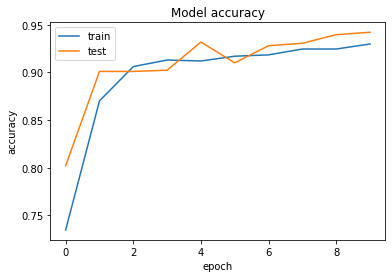

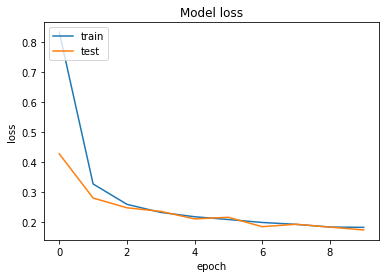

In [78]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()